## 目次
1. [概要](#anchor1)
1. [セットアップ](#anchor2)
1. [画像のラベル検出](#anchor3)
1. [動画のラベル検出](#anchor4)
---

<a id="anchor1"></a>
## 1. 概要
Amazon Rekognition では、イメージ分析とビデオ分析をアプリケーションに簡単に追加することができます。Amazon Rekognition API にイメージやビデオを指定するだけで、このサービスによってモノ、人物、テキスト、シーン、アクティビティを識別できます。不適切なコンテンツも検出できます。Amazon Rekognition では、高精度な顔分析、顔の比較、および顔の検索機能も備えています。顔の検出、分析、比較は、ユーザー検証、カタログ作成、人数計数、公共安全など、多岐にわたって活用できます。

本ハンズオンではAmazon Rekogntionのラベル検出を用いて、定点カメラを想定した画像・動画から歩行者・車の検出を行います。

---

<a id="anchor2"></a>
## 2. セットアップ
本ハンズオンでは[3章](#anchor3)で画像を用いたラベル検出、[4章](#anchor4)で動画を用いたラベル検出を行います。以降で利用するライブラリ・各種定数をここで読み込んでおきます。

In [1]:
# ノートブックの初期化
import boto3
import cv2
import glob
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont, ImageColor
import time
import os
import base64
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt


In [2]:
#　定数を設定
# Rekognitionで分析する画像のパスを設定
IMAGE_DIR='image'
SAMPLE_IMAGE_PATH = os.path.join(IMAGE_DIR, 'sample.jpg')
SAMPLE_FORMAT = 'jpg'

# Rekognitionで分析する動画のパスを設定
MOVIE_DIR='movie'
SAMPLE_MOVIE_PATH = os.path.join(MOVIE_DIR, 'sample.mp4')
MOVIE_IMAGES_DIR = os.path.join(MOVIE_DIR, 'images')

---
<a id="anchor3"></a>
## 3. 画像のラベル検出
本章では画像のラベル検出を行います。Rekogntionでは、物体(花、樹木、テーブルなど)、イベント（結婚式、卒業式、誕生日会など）、概念（風景、夜、自然など）のラベルを画像から検出することができます。Amazon Rekognition ImageのDetectLabels APIを実際に使ってみることで、どのような応答が返ってくるか試してみましょう。まずは以下のコードでrekognitionのClient APIを初期化します。

In [3]:
# rekognitionのClient APIを初期化
rekognition = boto3.client('rekognition')

次に、本章でラベル検出する対象の画像を見てみましょう。

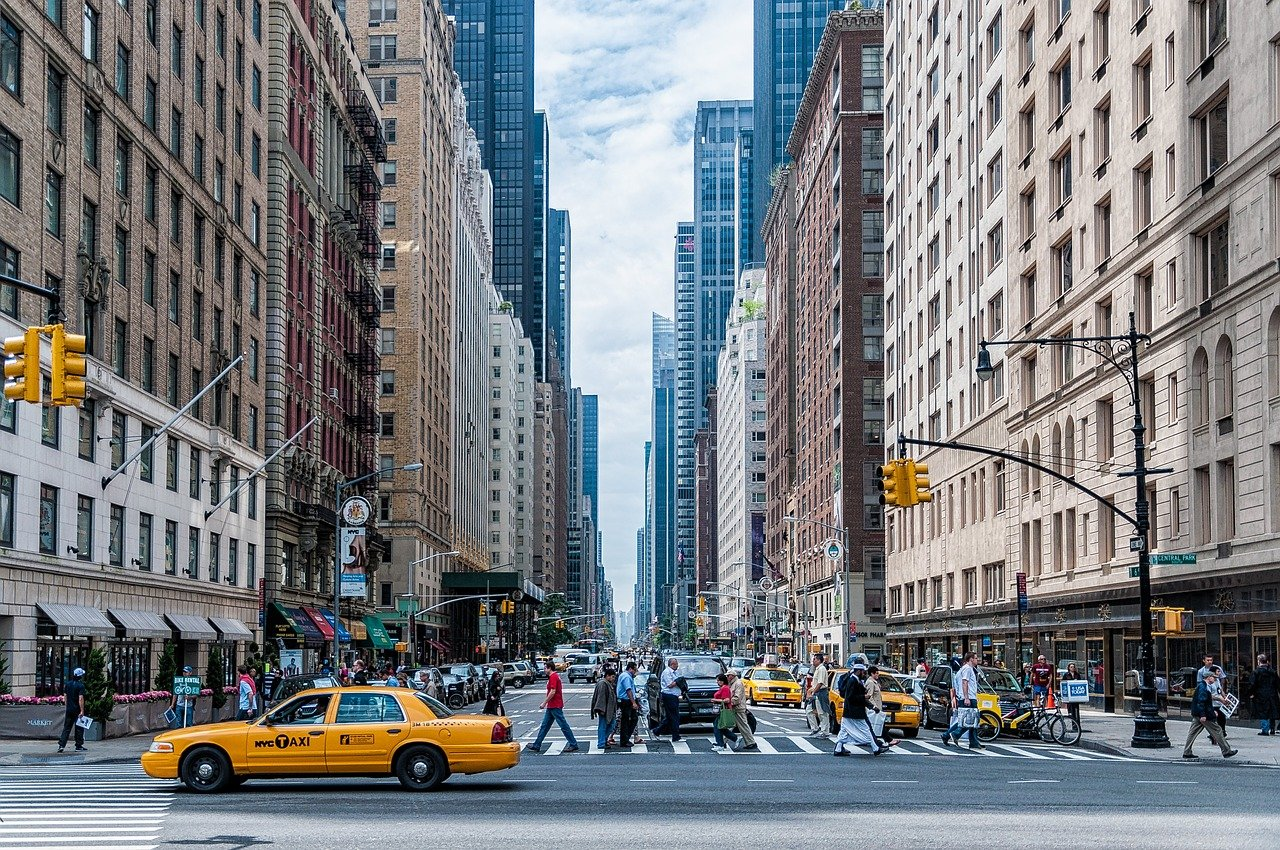

In [4]:
display(IImage(SAMPLE_IMAGE_PATH))

上記の画像をRekognitionで分析し、車・人をラベル検出できるのかを試してみましょう。以下のコードを実行します。

In [5]:
frame = cv2.imread(SAMPLE_IMAGE_PATH)
hasFrame, imageBytes = cv2.imencode(".png", frame)

# analyze an image using Amazon Rekognition Custom Labels endpoint
detectLabelsResponse = rekognition.detect_labels(
    Image={
        'Bytes': imageBytes.tobytes()
    }
)

Rekognitionでラベル検出する際は、DetectLabels APIを使用します。APIの詳細については[ドキュメント](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels)を参照下さい。
DetectLabels APIから返却された結果を見てみましょう。Person, Car, City, Traffic Lightなど様々なラベルが検出できていることがわかります。

In [6]:
print([list_['Name'] for list_ in detectLabelsResponse['Labels']])

['Person', 'Human', 'Car', 'Automobile', 'Vehicle', 'Transportation', 'City', 'Town', 'Urban', 'Building', 'Taxi', 'Cab', 'Road', 'Metropolis', 'Traffic Light', 'Light', 'Downtown', 'Intersection', 'High Rise']


返却された結果全てを見たい場合は以下のセルを実行してください。各ラベルの名称、信頼度(Confidence)、Bounding Boxの座標情報が返却されていることがわかります。

In [7]:
print(detectLabelsResponse)

{'Labels': [{'Name': 'Person', 'Confidence': 99.60660552978516, 'Instances': [{'BoundingBox': {'Width': 0.04172191768884659, 'Height': 0.10974867641925812, 'Left': 0.4138333797454834, 'Top': 0.7747583985328674}, 'Confidence': 99.60660552978516}, {'BoundingBox': {'Width': 0.04140186309814453, 'Height': 0.11941736191511154, 'Left': 0.924643874168396, 'Top': 0.7708889842033386}, 'Confidence': 98.84825897216797}, {'BoundingBox': {'Width': 0.0417058952152729, 'Height': 0.11231531202793121, 'Left': 0.650317907333374, 'Top': 0.7744323015213013}, 'Confidence': 98.83679962158203}, {'BoundingBox': {'Width': 0.028005313128232956, 'Height': 0.11416015774011612, 'Left': 0.7407611608505249, 'Top': 0.7640278935432434}, 'Confidence': 98.8312759399414}, {'BoundingBox': {'Width': 0.02172088623046875, 'Height': 0.10726232081651688, 'Left': 0.4791005551815033, 'Top': 0.7718398571014404}, 'Confidence': 98.80879974365234}, {'BoundingBox': {'Width': 0.015932369977235794, 'Height': 0.059793200343847275, 'Left

今回は画像から人・車の検出ができるかどうかに焦点を当てます。以下のコードで返却された結果から人(Person)・車(Car)のみを抽出し元画像にラベルを描画してみましょう。

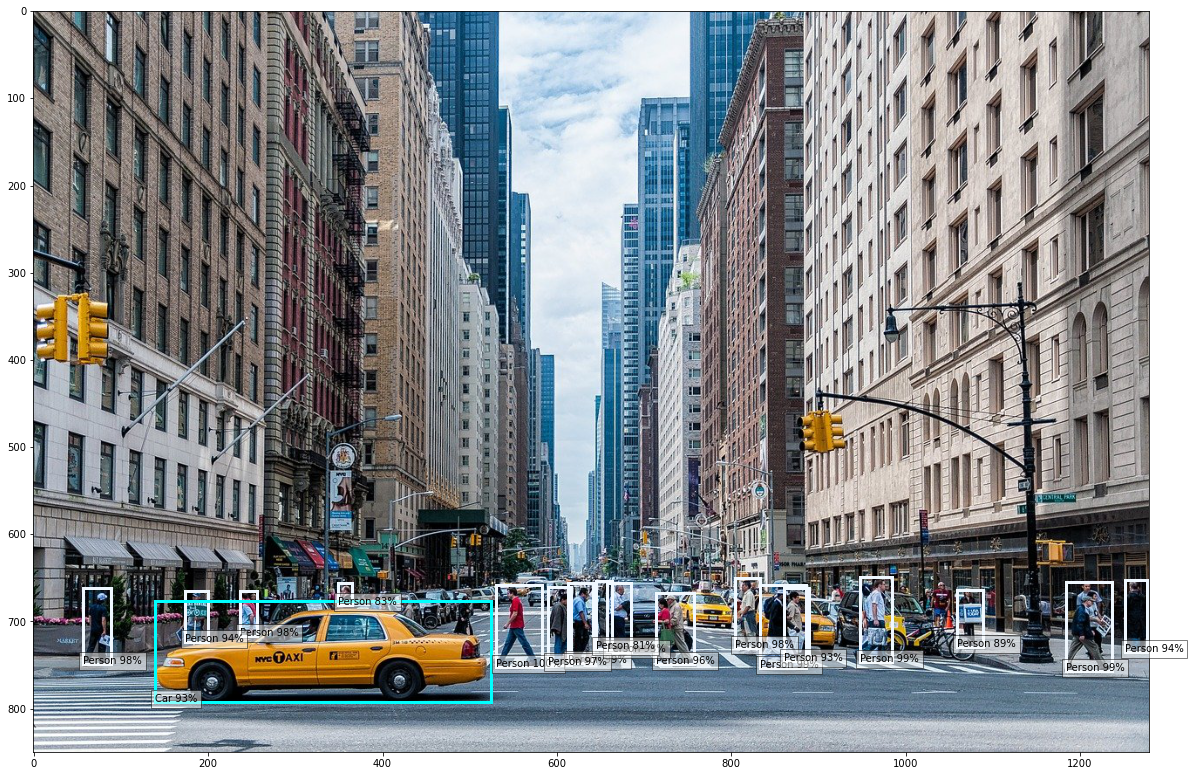

In [8]:
colors = list(ImageColor.colormap.values())
image_np = np.array(Image.open(SAMPLE_IMAGE_PATH))
plt.figure(figsize=(20,20))
ax = plt.axes()
ax.imshow(image_np)

# 描画する対象のリストを作成
detect_list = ['Person', 'Car']
class_num = len(detect_list)
for idx, label in enumerate(detectLabelsResponse['Labels']):
    if label['Name'] not in detect_list:
        continue
    label_name = label['Name']
    for instance in label['Instances']:
        if instance['Confidence'] < 80:
            continue
        instance['BoundingBox']
        left=instance['BoundingBox']['Left']
        top=instance['BoundingBox']['Top']
        right=instance['BoundingBox']['Width'] + left
        bot=instance['BoundingBox']['Height'] + top
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        color = colors[hash(idx) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, '{} {:.0f}%'.format(label_name, instance['Confidence']), bbox=dict(facecolor='white', alpha=0.5))        


上記の結果から、画像内に存在している人・車をラベル検出できていることがわかります。Rekognitionがサポートしているラベルのフルセットは[こちら](https://d2aslwxpztrh8x.cloudfront.net/1d2f4f70-e269-4194-9bee-c4b31eb99266/AmazonRekognitionLabels_v2.0.zip)からダウンロードできます。

<a id="anchor4"></a>
## 4. 動画のラベル検出

本章では動画のラベル検出を行います。本ハンズオンでは、動画(mp4)を連番静止画に分割し、各画像に対して推論を実行、その結果を画像に重畳して最後に動画へ変換します。それでは以下のコードを実行し、rekognitionのClient APIを初期化します。

In [9]:
# rekognitionのClient APIを初期化
rekognition = boto3.client('rekognition')

次に、/movie下に格納されているsample.mp4を読み込み、連番の静止画に分割します。

In [10]:
def divideVideo(video_path, img_path):
    '''動画を静止画に分割する
    
    Args:
        video_path(str): 分割対象の動画のパス
        img_path: 分割した静止画の保存先パス
    
    Returns:
        
    
    '''

    # 静止画の保存先がまだ存在していなかった場合は作成
    if not os.path.isdir(img_path):
        os.mkdir(img_path)

    # 動画の読み込み
    cap = cv2.VideoCapture(video_path)
    
    # 動画を分割しPNG形式で保存
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        print("Processing frame id: {}".format(frameId))
        ret, frame = cap.read()
        if (ret != True):
            break
        img_name = 'image_' + str(int(frameId)).zfill(4) + '.png'
        path = os.path.join(img_path, img_name)
        cv2.imwrite(path, frame)
    
    cap.release()

divideVideo(SAMPLE_MOVIE_PATH, MOVIE_IMAGES_DIR)

Processing frame id: 0.0
Processing frame id: 1.0
Processing frame id: 2.0
Processing frame id: 3.0
Processing frame id: 4.0
Processing frame id: 5.0
Processing frame id: 6.0
Processing frame id: 7.0
Processing frame id: 8.0
Processing frame id: 9.0
Processing frame id: 10.0
Processing frame id: 11.0
Processing frame id: 12.0
Processing frame id: 13.0
Processing frame id: 14.0
Processing frame id: 15.0
Processing frame id: 16.0
Processing frame id: 17.0
Processing frame id: 18.0
Processing frame id: 19.0
Processing frame id: 20.0
Processing frame id: 21.0
Processing frame id: 22.0
Processing frame id: 23.0
Processing frame id: 24.0
Processing frame id: 25.0
Processing frame id: 26.0
Processing frame id: 27.0
Processing frame id: 28.0
Processing frame id: 29.0
Processing frame id: 30.0
Processing frame id: 31.0
Processing frame id: 32.0
Processing frame id: 33.0
Processing frame id: 34.0
Processing frame id: 35.0
Processing frame id: 36.0
Processing frame id: 37.0
Processing frame id: 3

Processing frame id: 309.0
Processing frame id: 310.0
Processing frame id: 311.0
Processing frame id: 312.0
Processing frame id: 313.0
Processing frame id: 314.0
Processing frame id: 315.0
Processing frame id: 316.0
Processing frame id: 317.0
Processing frame id: 318.0
Processing frame id: 319.0
Processing frame id: 320.0
Processing frame id: 321.0
Processing frame id: 322.0
Processing frame id: 323.0
Processing frame id: 324.0
Processing frame id: 325.0
Processing frame id: 326.0
Processing frame id: 327.0
Processing frame id: 328.0
Processing frame id: 329.0
Processing frame id: 330.0
Processing frame id: 331.0
Processing frame id: 332.0
Processing frame id: 333.0
Processing frame id: 334.0
Processing frame id: 335.0
Processing frame id: 336.0
Processing frame id: 337.0
Processing frame id: 338.0
Processing frame id: 339.0
Processing frame id: 340.0
Processing frame id: 341.0
Processing frame id: 342.0
Processing frame id: 343.0
Processing frame id: 344.0
Processing frame id: 345.0
P

上記で分割した静止画を順にラベル検出します。ラベル検出は[3章](#anchor3)と同様にDetectLabels APIを用いて行います。静止画についてラベル検出を行ったあと、OpenCVを用いてフレーム処理を行い、Bounding Boxを描画した動画を作成します。

In [11]:
def analyzeVideo(movie_path, img_path, analyzed_movie_path, detect):
    '''動画を解析する
    
    Args:
        movie_path(str): 解析対象の動画の保存先パス
        img_path(str): 分割した静止画の保存先パス
        analyzed_movie_path(str): 分析した動画の保存先パス
        detect (list) :検出したい対象のリスト
    
    '''
    # set movie's information
    mv= cv2.VideoCapture(movie_path)#動画の読み込み
    frame_count =int(mv.get(cv2.CAP_PROP_FRAME_COUNT))#動画のフレームをすべて取得
    frame_rate = int(mv.get(cv2.CAP_PROP_FPS))#読み込んだ動画のFPS(フレームレート)を調べる
    movie_width = int(mv.get(cv2.CAP_PROP_FRAME_WIDTH))
    movie_height = int(mv.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # settings for make video file
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(analyzed_movie_path, fourcc, frame_rate, (movie_width, movie_height))
    
    rekognition = boto3.client('rekognition')
    file_list = sorted(glob.glob(os.path.join(img_path, '*')))

    # analyze each image
    for i, d in enumerate(file_list):
        frameId = i+1 #current frame number
        print("Processing frame id: {}".format(frameId))
        frame = cv2.imread(d)
        #print(d)
        hasFrame, imageBytes = cv2.imencode(".png", frame)
        
        # ラベル検出
        response = rekognition.detect_labels(
            Image={
                'Bytes': imageBytes.tobytes()
            }
        )
        # draw rectangles on an image using the analysis results
        for output in response["Labels"]:
        #    print(output)
            Name = output['Name']
            if Name not in detect:
                continue

            Confidence = output['Confidence']
            for instance in output['Instances']:
                w = instance['BoundingBox']['Width']
                h = instance['BoundingBox']['Height']
                left = instance['BoundingBox']['Left']
                top = instance['BoundingBox']['Top']
                w = int(w * movie_width)
                h = int(h * movie_height)
                left = int(left*movie_width)
                top = int(top*movie_height)

                cv2.rectangle(frame,(left,top),(left+w,top+h),(0,0,255),2)
                cv2.rectangle(frame,(left,top-20),(left+len(Name)*8, top),(0,0,255),-1)
                cv2.putText(frame, Name + ': ' , (left, top-10), cv2.FONT_HERSHEY_SIMPLEX, 0.40,(255, 255, 255), 2)                    
        writer.write(frame)

    writer.release()
    cv2.destroyAllWindows()

# 人・車のみを検出するためリストを作成
detect_list = ['Person', 'Car']
analyzeVideo(SAMPLE_MOVIE_PATH, MOVIE_IMAGES_DIR, 'result.mp4', detect_list)

Processing frame id: 1
Processing frame id: 2
Processing frame id: 3
Processing frame id: 4
Processing frame id: 5
Processing frame id: 6
Processing frame id: 7
Processing frame id: 8
Processing frame id: 9
Processing frame id: 10
Processing frame id: 11
Processing frame id: 12
Processing frame id: 13
Processing frame id: 14
Processing frame id: 15
Processing frame id: 16
Processing frame id: 17
Processing frame id: 18
Processing frame id: 19
Processing frame id: 20
Processing frame id: 21
Processing frame id: 22
Processing frame id: 23
Processing frame id: 24
Processing frame id: 25
Processing frame id: 26
Processing frame id: 27
Processing frame id: 28
Processing frame id: 29
Processing frame id: 30
Processing frame id: 31
Processing frame id: 32
Processing frame id: 33
Processing frame id: 34
Processing frame id: 35
Processing frame id: 36
Processing frame id: 37
Processing frame id: 38
Processing frame id: 39
Processing frame id: 40
Processing frame id: 41
Processing frame id: 42
P

Processing frame id: 334
Processing frame id: 335
Processing frame id: 336
Processing frame id: 337
Processing frame id: 338
Processing frame id: 339
Processing frame id: 340
Processing frame id: 341
Processing frame id: 342
Processing frame id: 343
Processing frame id: 344
Processing frame id: 345
Processing frame id: 346
Processing frame id: 347
Processing frame id: 348
Processing frame id: 349
Processing frame id: 350
Processing frame id: 351
Processing frame id: 352
Processing frame id: 353
Processing frame id: 354
Processing frame id: 355
Processing frame id: 356
Processing frame id: 357
Processing frame id: 358
Processing frame id: 359
Processing frame id: 360
Processing frame id: 361
Processing frame id: 362
Processing frame id: 363
Processing frame id: 364
Processing frame id: 365
Processing frame id: 366
Processing frame id: 367
Processing frame id: 368
Processing frame id: 369
Processing frame id: 370
Processing frame id: 371
Processing frame id: 372
Processing frame id: 373


上記のコードを実行すると、同一階層にresult.mp4が生成されているので、確認してみましょう。動画でも問題なくラベル検出ができていることがわかります。今回は動画を静止画に分割し、Amazon Rekognitionでラベル検出を行なう手法をご紹介しました。この手法はリアルタイムに動画を分析する際によく使われる手法です。リアルタイムな動画分析の場合、ラベル検出はRekognitionではなくSageMakerで独自に学習モデルを作成してデプロイした推論エンドポイントに対しても行われることもあります（参考：[Amazon Kinesis Video Streams および Amazon SageMaker を使用したリアルタイムでのライブビデオの分析](https://aws.amazon.com/jp/blogs/news/analyze-live-video-at-scale-in-real-time-using-amazon-kinesis-video-streams-and-amazon-sagemaker/)）。
上記手法のほか、Amazon Rekognition Videoを用いても動画のラベル検出を行うことができます。Amazon Rekogntion Videoは、Amazon S3 に保存されているビデオから、物体、シーン、有名人、テキスト、動作、および不適切なコンテンツを検出する、機械学習を利用したビデオ分析サービスです。また、Rekognition Video は精度の高い顔分析および顔検索機能も備えており、顔の検出、分析、比較が行えるほか、ビデオ内での人物の動きを追跡することもできます。Amazon Rekognition Videoで動画のラベル検出をするとどのような結果が返ってくるのか確認してみましょう。Amazon Rekognition Videoを用いるには、分析したい対象の動画をS3バケットに格納する必要があります。まずは以下のコードを実行してS3バケットを作成し、分析したい動画を格納しましょう。

In [13]:
import uuid
S3_BUCKET = 'rekognition-video-handson' + str(uuid.uuid4()) # 一意の文字列にするためUUIDを付与
region = boto3.session.Session().region_name
location = {'LocationConstraint': region}
s3_client = boto3.client('s3')
response = s3_client.create_bucket(Bucket=S3_BUCKET,CreateBucketConfiguration=location)
s3_client.upload_file(SAMPLE_MOVIE_PATH, S3_BUCKET, SAMPLE_MOVIE_PATH)

上記でS3に格納したパスを指定して、Rekognition Videoでのラベル検出を行います。

In [16]:
response = rekognition.start_label_detection(
    Video={'S3Object': 
           {'Bucket': S3_BUCKET, 
            'Name': SAMPLE_MOVIE_PATH
           }
          }
    )

下記のコードを実行し、分析の状態がSUCCEEDEDとなるまで待ちます。IN_PROGRESSと出力された場合は、少し時間を置いてから再度上記のコードを実行してください。

In [32]:
result = rekognition.get_label_detection(JobId=response['JobId'])
print(result['JobStatus'])

SUCCEEDED


上記のコードを実行しSUCCEEDEDと表示されたら、動画のラベル検出は終了しています。GetLabelDetection APIから返却された結果を見てみましょう。

In [33]:
print(result)

{'JobStatus': 'SUCCEEDED', 'VideoMetadata': {'Codec': 'h264', 'DurationMillis': 19887, 'Format': 'QuickTime / MOV', 'FrameRate': 29.970029830932617, 'FrameHeight': 540, 'FrameWidth': 960, 'ColorRange': 'LIMITED'}, 'NextToken': 'NqKSmT69mJssghl5qldzJpg+ga7D/9e9CHBpWk13P1z+we22opx4vbzh9unrIIWmm/YIljpGdB7Z', 'Labels': [{'Timestamp': 0, 'Label': {'Name': 'Advertisement', 'Confidence': 66.69607543945312, 'Instances': [], 'Parents': []}}, {'Timestamp': 0, 'Label': {'Name': 'Asphalt', 'Confidence': 55.08290481567383, 'Instances': [], 'Parents': []}}, {'Timestamp': 0, 'Label': {'Name': 'Automobile', 'Confidence': 97.17041015625, 'Instances': [], 'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]}}, {'Timestamp': 0, 'Label': {'Name': 'Billboard', 'Confidence': 66.69607543945312, 'Instances': [], 'Parents': [{'Name': 'Advertisement'}]}}, {'Timestamp': 0, 'Label': {'Name': 'Building', 'Confidence': 96.92424011230469, 'Instances': [], 'Parents': []}}, {'Timestamp': 0, 'Label': {'Name': '

結果を見ると、時間(Timestamp)ごとにラベル検出されていることがわかります。本ハンズオンでは割愛しますが、この結果を用いて動画に対してフレーム処理を行うことで、Bounding Boxを描画した動画を作成することができます。
GetLabelDetection APIからのレスポンスの詳細は[ドキュメント](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.get_label_detection)を参照してください。

<a id="anchor5"></a>
## 5. リソースの削除
本ハンズオンで作成したリソースの削除を行います。

In [34]:
response = s3_client.delete_bucket(Bucket=S3_BUCKET)

ClientError: An error occurred (AccessDenied) when calling the DeleteBucket operation: Access Denied